In [1]:
import pandas as pd
import sys
import numpy as np
from cameras.cameras import Amount, Camera, mean_squash_camera, wiggle_camera
from evolution.base import BaseGeometry, DenseGeometry, PlaneGeometry
from evolution.camera.camera_rendering import project_points, render_geometry_with_camera
from evolution.camera import CameraTranslator, ObjGeometry
from evolution.strategies import DistanceMap, DistanceMapWithPunishment
import cv2 as cv
import matplotlib.pyplot as plt
print(sys.executable)

/home/chris/Development/virtualenvironments/evolution-evaluation/bin/python


Development of a function for loading results

In [2]:
results_df = pd.read_csv("data/squash_full_data.csv")
results_df[["t_fu", "t_fv", "t_tx", "t_rz", "t_d3", "t_d2"]].describe()

,t_fu,t_fv,t_tx,t_rz,t_d3,t_d2
count,55296.0,55296.0,55296.0,55296.0,55296.0,55296.0
mean,700.0,700.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,700.0,700.0,0.0,0.0,0.0,0.0
25%,700.0,700.0,0.0,0.0,0.0,0.0
50%,700.0,700.0,0.0,0.0,0.0,0.0
75%,700.0,700.0,0.0,0.0,0.0,0.0
max,700.0,700.0,0.0,0.0,0.0,0.0


In [3]:
configurations_df = results_df[["fitness_fn", "distance_type", "noise_type", "noise_value"]].drop_duplicates()
configurations_df

,fitness_fn,distance_type,noise_type,noise_value
0,DistanceMapWithPunishment,Near,no_noise,0.00
32,DistanceMapWithPunishment,Near,salt,0.01
64,DistanceMapWithPunishment,Near,hlines,128.00
96,DistanceMapWithPunishment,Near,vlines,128.00
128,DistanceMapWithPunishment,Near,straight_grid,128.00
160,DistanceMapWithPunishment,Near,angled_grid,128.00
4608,DistanceMap,Near,no_noise,0.00
4640,DistanceMap,Near,salt,0.01
4672,DistanceMap,Near,hlines,128.00
4704,DistanceMap,Near,vlines,128.00


In [4]:
for configuration in configurations_df:
    print(configuration)

fitness_fn
distance_type
noise_type
noise_value


In [5]:
mean_squash_camera((800, 600)).dna

array([7.00e+02, 7.00e+02, 3.00e+02, 4.00e+02, 0.00e+00, 2.35e+00,
       8.40e+00, 2.90e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00])

In [6]:
def translate_dna(camera_dna: np.array):
    x = camera_dna
    camera_matrix = np.array([[x[0], 0, x[2]], [0, x[1], x[3]], [0, 0, 1]], dtype=np.float32)

    t_vec = x[4:7].astype(np.float32)
    r_vec = x[7:10].astype(np.float32)
    d_vec = x[10:].astype(np.float32)

    return camera_matrix, t_vec, r_vec, d_vec

def reprojection_error(camera_a: Camera, camera_b: Camera, geometry: BaseGeometry) -> float:
    cma, ta, ra, da = translate_dna(camera_a.dna)
    cmb, tb, rb, db = translate_dna(camera_b.dna)
    projected_points_a = project_points(geometry.world_points, cma, ta, ra, da)
    projected_points_b = project_points(geometry.world_points, cmb, tb, rb, db)
    projected_points_a = projected_points_a.reshape((-1,2))
    projected_points_b = projected_points_b.reshape((-1,2))
    errors = projected_points_b - projected_points_a
    return errors


In [7]:
geometry_file = "data/squash/geometries/squash_court.obj"
image_shape = (600, 800)
geometry = ObjGeometry(geometry_file)
geometry_dense = DenseGeometry(geometry, 16)
geometry_y0 = PlaneGeometry(geometry, 0, 16)

cam_a = mean_squash_camera(image_shape)
cam_b = wiggle_camera(cam_a, Amount.near(), [i for i in range(15)], 7)


In [8]:
reprojection_error(cam_a, cam_b, geometry_dense)

array([[-16.48931416, -14.8967359 ],
       [-16.42518751, -13.86625284],
       [-15.90234986, -12.80318304],
       ...,
       [ -4.0606502 ,  -2.78692034],
       [ -3.92066949,  -2.4538042 ],
       [ -3.79267935,  -2.15189818]])

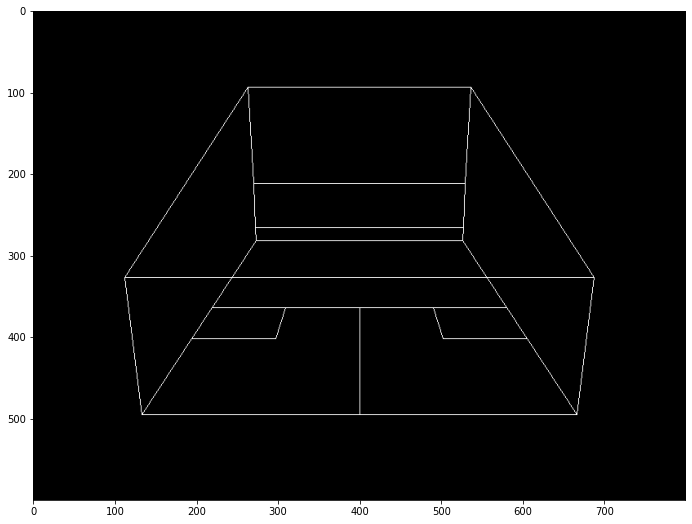

In [8]:
test_image = np.zeros(image_shape, dtype=np.uint8)
cma, ta, ra, da = translate_dna(cam_a.dna)
cmb, tb, rb, db = translate_dna(cam_b.dna)

render_geometry_with_camera(test_image, geometry, cma, ta, ra, da, (255,), 1)
render_geometry_with_camera(test_image, geometry_y0, cma, ta, ra, da, (255), 2, cv.MARKER_CROSS)
render_geometry_with_camera(test_image, geometry_dense, cma, ta, ra, da, (64), 1, cv.MARKER_CROSS)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.imshow(test_image,cmap="gray")

# Distance lookup maps image

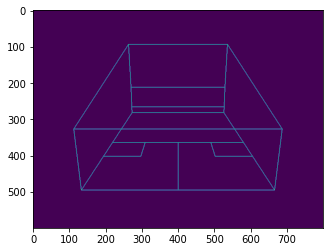

In [9]:
image0 = np.zeros(image_shape, dtype=np.uint8)
render_geometry_with_camera(image0, geometry, cma, ta, ra, da, (255,), 1)

plt.imshow(image0)

In [10]:
errors = np.array([[-5.13359926, -1.00286623],
 [ 3.90467068,  0.17045128],
 [ 2.49603298,  1.24115201],
 [-3.15903772, -0.47393416],
 [-4.35515419, -0.65016197],
 [-1.67511372, -0.21691813],
 [-1.6319287 , -0.10469017],
 [-3.995781  , -0.5593235 ],
 [ 2.29013444,  0.64383736],
 [ 3.5814802 ,  1.07137424],
 [ 3.31666919,  1.2486702 ],
 [ 2.02222241,  0.79929648],
 [ 0.93745444, -0.4128502 ],
 [ 0.37337842,  0.34817974],
 [-2.84210926, -2.81428821],
 [ 4.0406909 ,  0.51757779],
 [ 3.44067235,  1.24932344],
 [-1.38665265, -1.69710027],
 [-3.0063671 , -0.64745206],
 [ 2.58314506,  1.17000407],
 [-2.50907942, -1.12098788],
 [ 2.85299371,  1.03637041]])

In [11]:


print(distances)
print()
print(errors.shape)
print(distances.shape)


NameError: name 'distances' is not defined

In [12]:
checkpoints = []

for i in range(5):
    checkpoint_x, checkpoint_y = i, i**2
    checkpoints.append([checkpoint_x, checkpoint_y])

print("   checkpoints: ", checkpoints)
print("checkpoints[3]: ", checkpoints[3])

#   checkpoints:  [[0, 0], [1, 1], [2, 4], [3, 9], [4, 16]]
#checkpoints[3]:  [3, 9]

   checkpoints:  [[0, 0], [1, 1], [2, 4], [3, 9], [4, 16]]
checkpoints[3]:  [3, 9]


In [13]:
import pandas as pd
from pathlib import Path
from functools import reduce

In [14]:
filename = "the_df.csv"

In [15]:
append_mode = True
_header = ("B", "A", "D")

if Path(filename).is_file() and append_mode:
    print(f"FILE EXISTS, {append_mode=}")
    the_df = pd.read_csv(filename)
    loaded_header = the_df.columns
    if len(loaded_header) != len(_header):
        print("INCONSISTENCY IN HEADER LENGTH")
    r = [_lh == _h for _lh, _h in zip(loaded_header, _header)]
    all_true = reduce((lambda x, y: x and y), r)
    if not all_true:
        print("INCONSISTENCY IN HEADER NAMES")

        
else:
    print(f"NEW FILE, {append_mode=}")
    the_df = pd.DataFrame(columns=_header)
    the_df.to_csv(filename, index=False)

the_df

new_row = {"A": 0, "C": 1, "D": 123}
the_df = the_df.append(new_row, ignore_index=True)
the_df.to_csv(filename, index=False)


NEW FILE, append_mode=True


In [16]:
filename

'the_df.csv'

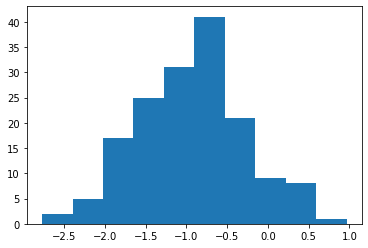

In [20]:
mu = 0
sigma = 1
lnormal = np.random.normal(mu, 0.7, 160) - 1 

fig = plt.figure()
ax0 = fig.add_subplot()
_ = ax0.hist(lnormal)

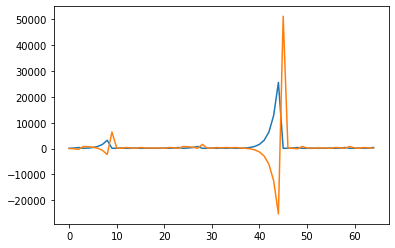

In [78]:
n_spins = 64
spins = np.random.rand(n_spins) <= 0.5

initial_bet = 100
bet = initial_bet
winnings = [0]
bets = [bet]
for spin in spins:
    if spin:
        winnings.append(2 * bet)
        bet = initial_bet
    else:
        winnings.append(winnings[-1]-bet)
        bet *= 2
    bets.append(bet)
plt.plot(bets)
plt.plot(winnings)


# Testing random choices

In [2]:
from random import choices
from collections import Counter
import numpy as np


In [2]:
population = ["A", "B", "C"]
weightsA = [1, 2, 100]
s = sum(weightsA)
weightsB = [w/s for w in weightsA]

N = 1000090
CA = Counter("".join(choices(population, weightsA, k=N)))
CB = Counter("".join(choices(population, weightsB, k=N))) 

print(CA)
print(CB)

Counter({'C': 971070, 'B': 19363, 'A': 9657})
Counter({'C': 971091, 'B': 19217, 'A': 9782})


In [7]:
population = ["A", "B", "C", "D", "E", "F", "G", "H"]

k = 4 # tournament size
p = 0.5
a = np.arange(k)
probabilities = p * ((1-p)**a)
print(probabilities)
participant_idx = np.random.choice(len(population), k, replace=False) # Select uniformly distributed unique participants (solutions)
tournament_idx = sorted(participant_idx) # sort indices, so that the best fit idx is located at 0
choices(tournament_idx, weights=probabilities, k=2)
sorted(np.random.choice(len(population), k, replace=False))

[0.5    0.25   0.125  0.0625]


[0, 4, 5, 7]

In [55]:
ga = "ABCDEFGHIJ"
gb = "0123456789"
p = 0.1
s = np.random.sample(len(ga)) > p

ca = "".join([a if i else b for (a, b, i) in zip(ga, gb, s)])
cb = "".join([b if i else a for (a, b, i) in zip(ga, gb, s)])

print(ga)
print(gb)
print(ca)
print(cb)



ABCDEFGHIJ
0123456789
ABCDEFGHIJ
0123456789


In [134]:


# Bounded uniform mutation
NGENES = 100
mutmin = [-1] * NGENES
mutmax = [+1] * NGENES
mutpro = [0.05] * NGENES
mutation_values = np.random.uniform(mutmin, mutmax)
mutation_selector = np.random.random_sample(NGENES) <= mutpro

print(f"{mutation_values=}")
print(f"{mutation_selector=}")

mutation_values[~mutation_selector] = 0
print(f"{mutation_values=}")
print(f"mutated genes: {len(mutation_selector[mutation_selector])}")



mutation_values=array([ 0.67011759, -0.60747385,  0.85200563, -0.3531038 , -0.92272567,
        0.26987228,  0.73569031,  0.47505831, -0.22865558,  0.95850876,
        0.30642699, -0.41218769, -0.34346267,  0.91788935, -0.41943265,
        0.10816801,  0.05409091,  0.67274775,  0.63093851, -0.44127158,
       -0.10579853, -0.53944473, -0.52280021,  0.60374847, -0.17769878,
       -0.63285523, -0.68211405, -0.36793518,  0.53080292,  0.65577102,
       -0.14076195, -0.84455003, -0.58169257, -0.72867945, -0.1140703 ,
        0.42471234, -0.56291533, -0.72464592, -0.06610002, -0.66175112,
       -0.21163058, -0.20049215, -0.78226652,  0.96483885, -0.86806918,
        0.62260212, -0.95087035, -0.32942691,  0.14839981, -0.36742813,
        0.18333426, -0.47942443,  0.8819654 , -0.6275208 , -0.37635479,
       -0.88666864,  0.48457081,  0.94410543, -0.08745314, -0.66534788,
       -0.3347933 ,  0.73482011,  0.99343548, -0.86586061,  0.99521961,
       -0.29804084, -0.1286734 ,  0.09337246,  0

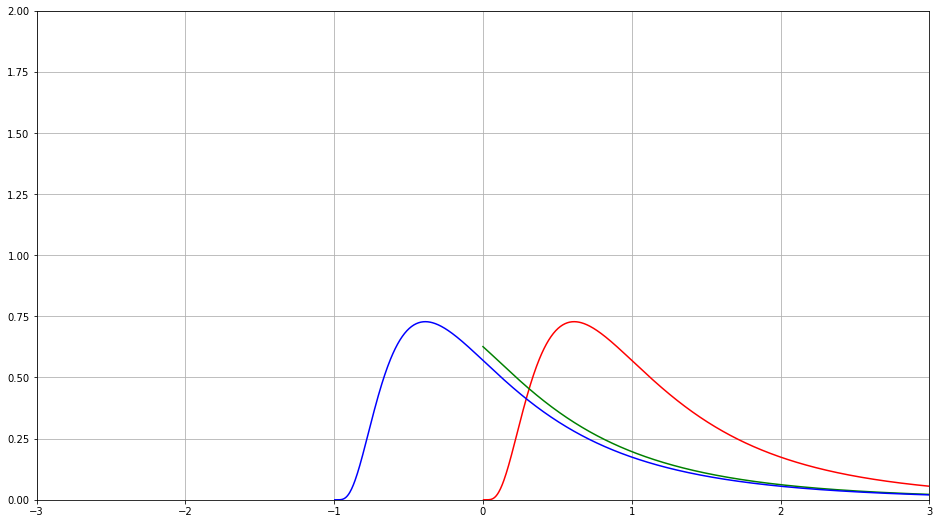

In [201]:
plt.figure(figsize=(16,9))

x = np.linspace(0, 4, 1024)

def log_normal(mu, sigma):
    return (1 / (np.sqrt(2*np.pi) * sigma * x)) * np.exp(-( (np.log(x) - mu)**2 / (2*sigma**2)))

def log_normal_alt(mu, sigma, o=0):
    return (1 / (np.sqrt(2*np.pi) * sigma * (x+o))) * np.exp(-( (np.log((x+o)) - mu)**2 / (2*sigma**2)))

import matplotlib.pyplot as plt


for mu in [0]:
    for sigma in [0.7]:
        plt.plot(x, log_normal(mu, sigma), 'r')
        plt.plot(x, log_normal_alt(mu, sigma, 0.9), 'g')
        plt.plot(x-1, log_normal(mu, sigma), 'b')
plt.xlim([-3, 3])
plt.ylim([0, 2])
plt.grid()


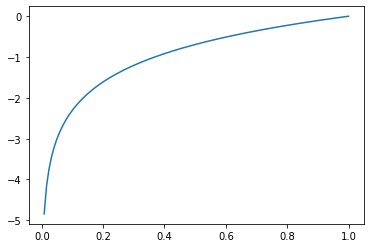

In [208]:
xt = np.linspace(0, 1, 128)
yt = np.log(xt)
plt.plot(xt, yt)